# Fibril Generator and CyRSoXS Simulation

In [1]:
from scipy.interpolate import interp1d
from scipy.ndimage import rotate
from sklearn.preprocessing import normalize
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import trimesh
import os
import pyembree
import random
import pickle
import sys
import pathlib
import subprocess
import h5py

from PyHyperScattering.load import cyrsoxsLoader
from PyHyperScattering.integrate import WPIntegrator

import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib import cm
from matplotlib.colors import LogNorm

import numpy as np
import io
from PIL import Image
import PIL

import open3d as o3d

%load_ext autoreload
%autoreload 2
%matplotlib inline

C:\Users\Phong\anaconda3\envs\smi_analysis\lib\site-packages\PyHyperScattering\load.py:1: UserWarning: Could not import astropy.io.fits, needed for ALS 11.0.1.2 RSoXS loading.  Is this dependency installed?
  from PyHyperScattering.ALS11012RSoXSLoader import ALS11012RSoXSLoader


Imports failed.  Are you running on a machine with proper libraries for databroker, tiled, etc.?


C:\Users\Phong\anaconda3\envs\smi_analysis\lib\site-packages\PyHyperScattering\integrate.py:3: UserWarning: Could not import CuPy or ndigpu.  If you expect this machine to support CuPy, check dependencies.  Falling back to scikit-image/numpy CPU integration.
  from PyHyperScattering.WPIntegrator import WPIntegrator
C:\Users\Phong\anaconda3\envs\smi_analysis\lib\site-packages\PyHyperScattering\util.py:4: UserWarning: Could not import package for interactive integration utils.  Install holoviews and scikit-image.
  from PyHyperScattering import IntegrationUtils


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Define path to NRSS and PyHyperScattering

In [2]:
sys.path.append('C:/Users/Phong/NRSS/')
sys.path.append('C:/Users/Phong/DopantModeling')
from NRSS.writer import write_materials, write_hdf5, write_config, write_slurm
from NRSS.checkH5 import checkH5
from Morphology import Morphology
from Fibril import Fibril
from PostProcessor import PostProcessor

## Define and generate fibril morphology

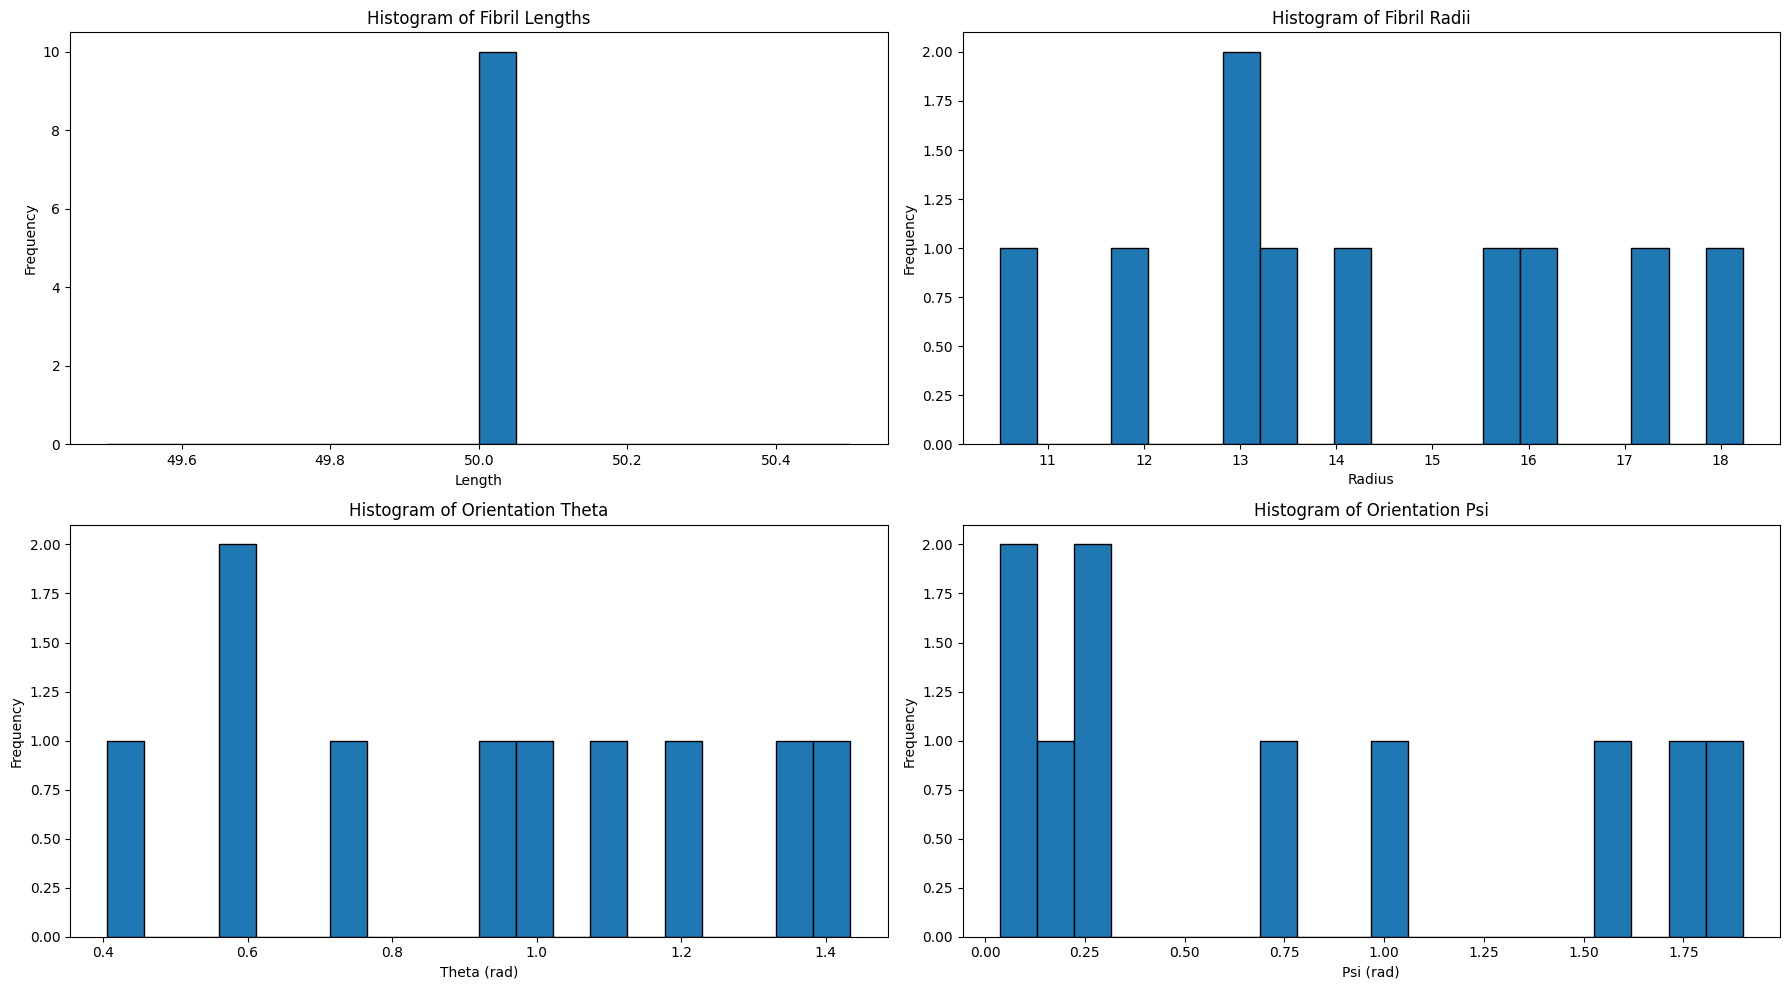

Filling model: 100%|███████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.56it/s]


In [58]:
# Declare model box size in nm (x,y,z)
x_dim_nm  = 200
y_dim_nm  = 200
z_dim_nm  = 200
pitch_nm = 2 # Dimension of voxel in nm

# Initialize morphology
morphology = Morphology(x_dim_nm, y_dim_nm, z_dim_nm, pitch_nm)
morphology.set_model_parameters(radius_nm_avg = 15,
                                radius_nm_std = 3,
                                max_num_fibrils = 10,
                                fibril_length_range_nm = [50, 50],
                                theta_distribution_csv = r'C:\Users\Phong\DopantModeling\theta_distributions\avg_0p1_theta_distribution.csv')

morphology.fill_model(timeout = 10, plot_histogram=True)

In [59]:
# May not show if the morphology is too large (too many fibrils)
scene = morphology.get_scene(show_bounding_box=True)
scene.show()

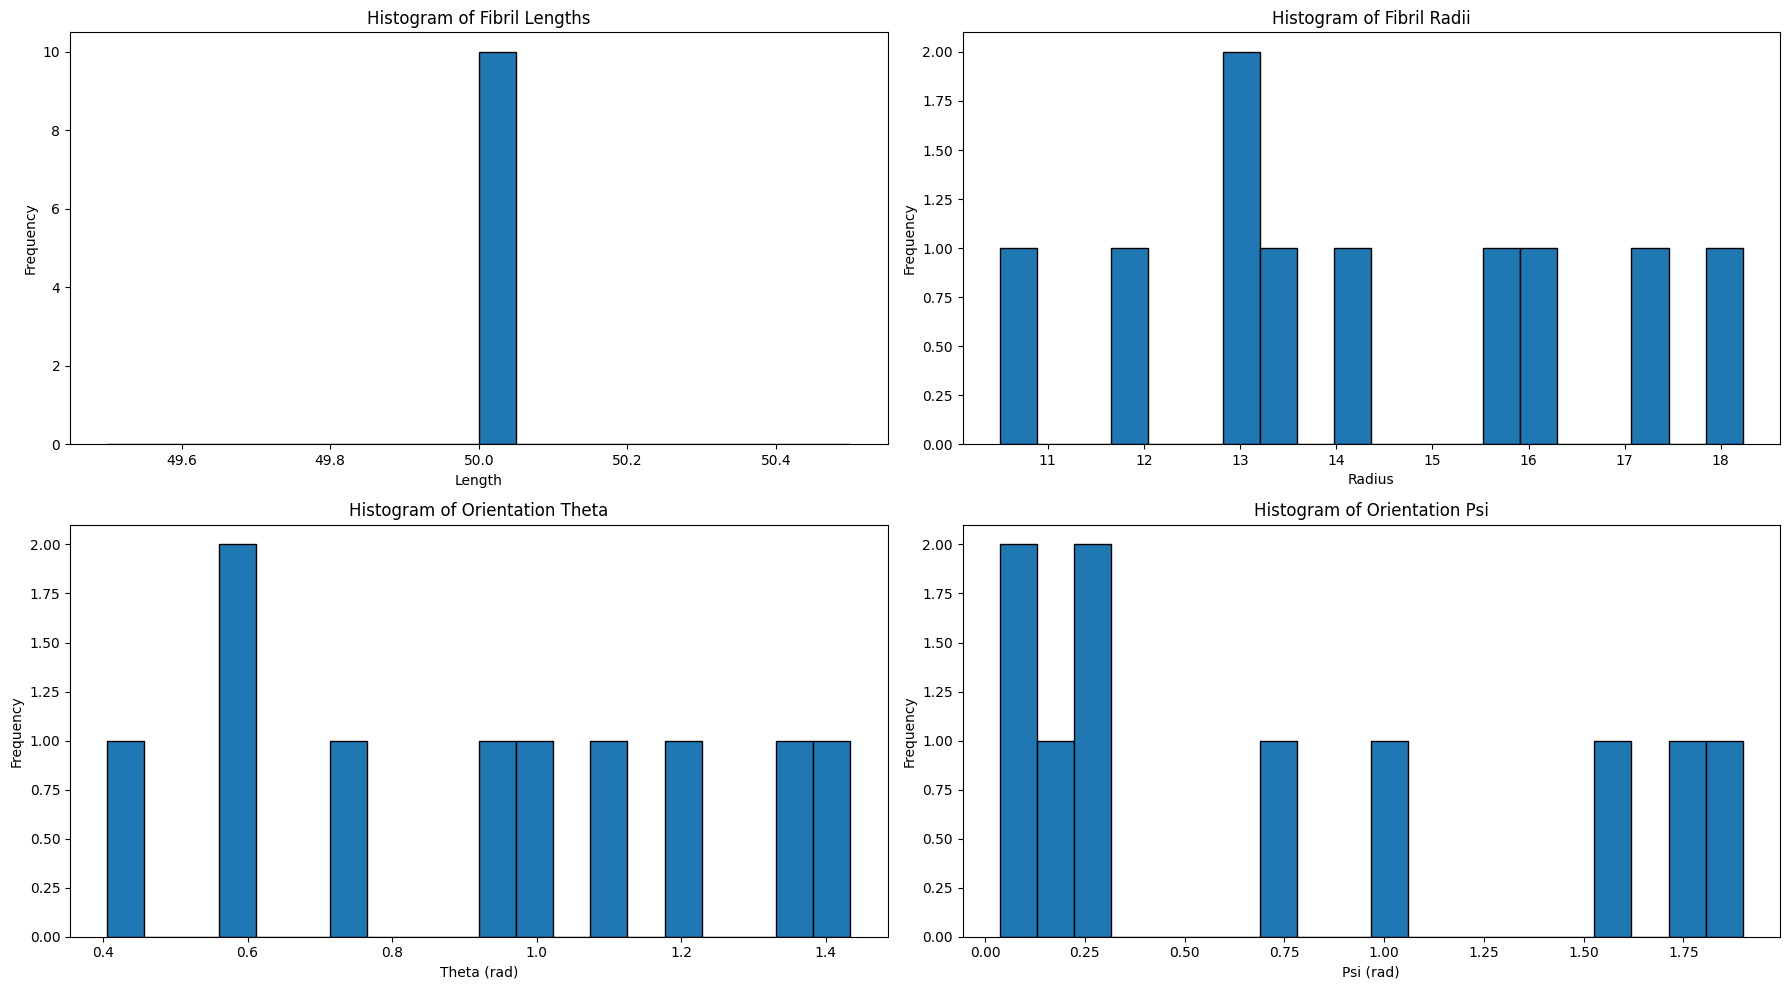

In [60]:
fig, ax = morphology.plot_fibril_histogram()

In [61]:
morphology.voxelize_model()

Voxelizing Fibrils: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.15it/s]


## Save voxelized morphology as reduced morphology

In [62]:
from ReducedMorphology import ReducedMorphology
rm = ReducedMorphology(morphology)

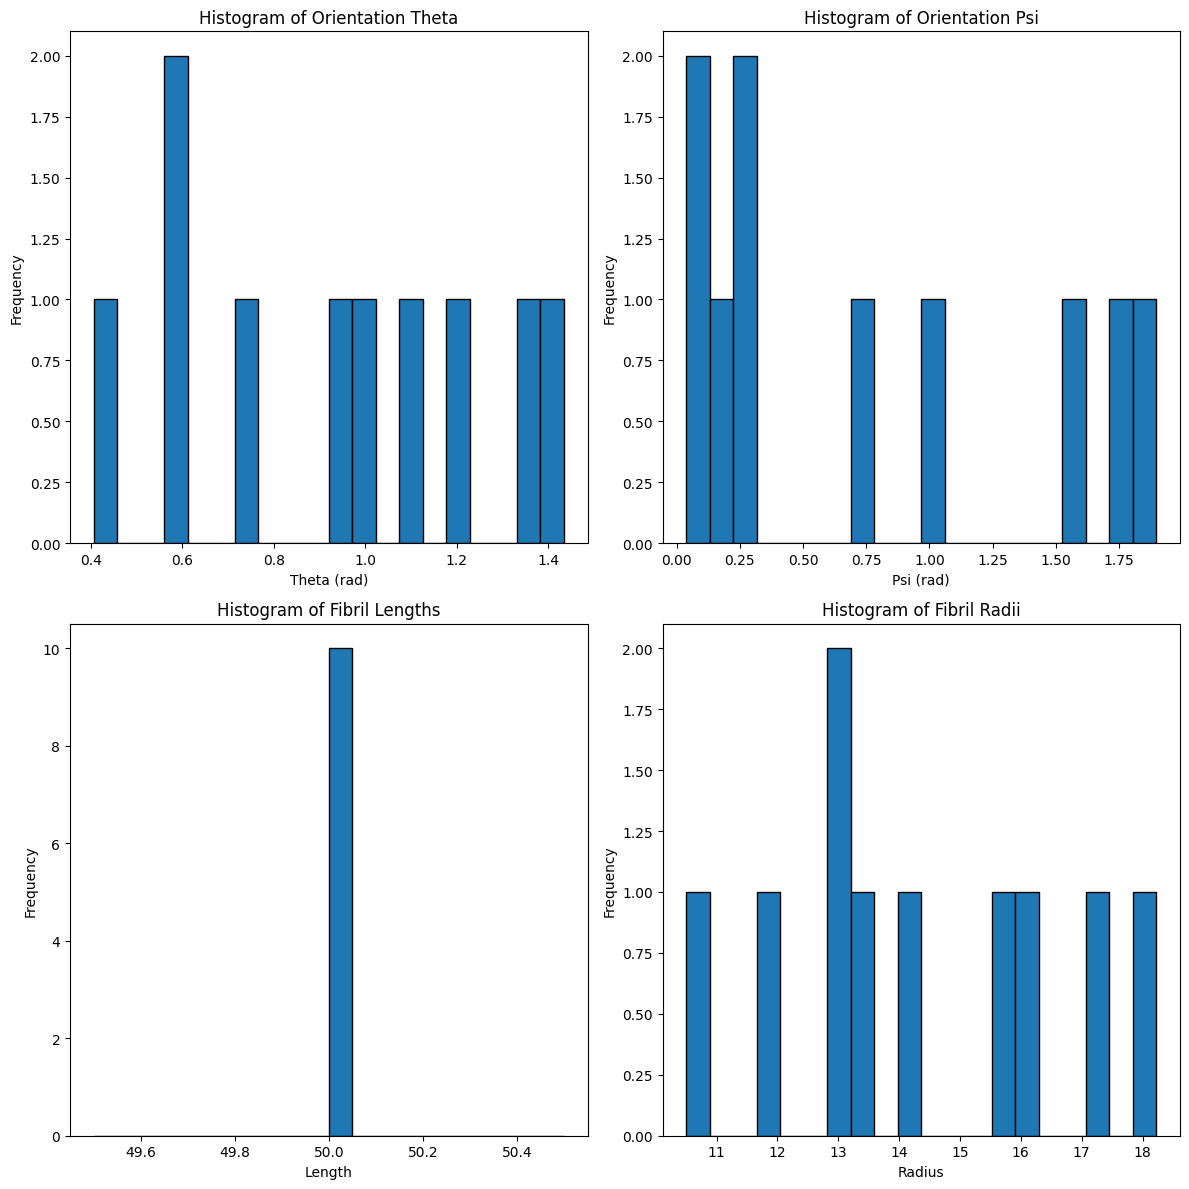

(<Figure size 1200x1200 with 4 Axes>,
 array([[<AxesSubplot:title={'center':'Histogram of Orientation Theta'}, xlabel='Theta (rad)', ylabel='Frequency'>,
         <AxesSubplot:title={'center':'Histogram of Orientation Psi'}, xlabel='Psi (rad)', ylabel='Frequency'>],
        [<AxesSubplot:title={'center':'Histogram of Fibril Lengths'}, xlabel='Length', ylabel='Frequency'>,
         <AxesSubplot:title={'center':'Histogram of Fibril Radii'}, xlabel='Radius', ylabel='Frequency'>]],
       dtype=object))

In [63]:
rm.plot_fibril_histogram()

In [64]:
rm.pickle()

## Load voxelized reduced morphology

In [65]:
from PostProcessor import PostProcessor

most_recent_file = None
most_recent_mtime = 0

# Iterate through all subdirectories and find the most recently modified .pickle file
for root, dirs, files in os.walk('.'):
    for filename in files:
        if filename.endswith('.pickle') and 'HDF5' not in os.listdir(root):
            full_path = os.path.abspath(os.path.join(root, filename))
            mtime = os.path.getmtime(full_path)
            if mtime > most_recent_mtime:
                most_recent_mtime = mtime
                most_recent_file = full_path

# Load the most recently modified .pickle file
rm = None
if most_recent_file:
    print(f"Loading the most recently modified file: {most_recent_file}")
    with open(most_recent_file, 'rb') as f:
        rm = pickle.load(f)
else:
    print("No pickle files found.")

Loading the most recently modified file: C:\Users\Phong\DopantModeling\Jupyter Notebooks\200x200x200nm_pitch2nm_rad15nm_std3nm_10fib_50-50nm.pickle


## Create material matricies

In [79]:
VACUUM_ID  = 0 # Vacuum
CRYSTAL_ID = 1 # Crystalline P3HT
AMORPH_ID  = 2 # Amorphous P3HT
DOPANT_ID  = 3 # Dopant (optional)

mol_weight = {
    CRYSTAL_ID: 166.2842, # Molecular weight of crystalline P3HT
    AMORPH_ID: 166.2842,  # Molecular weight of amorphous P3HT
    DOPANT_ID: 280.14     # Molecular weight of TFSI- = 280.14, Molecular weight of F4TCNQ = 276.15
}

density = {
    CRYSTAL_ID: 1.1, # Density of crystalline P3HT
    AMORPH_ID: 1.1,  # Density of amorphous P3HT
    DOPANT_ID: 1.1   # Density of dopant in P3HT
}

# PostProcessor Setup
post_processor = PostProcessor(
    num_materials=4, mol_weight=mol_weight, density=density,
    dope_case=1, dopant_method='preferential', dopant_orientation='perpendicular', dopant_vol_frac=0.0825, crystal_dope_frac = 0,
    core_shell_morphology=True, gaussian_std=3, fibril_shell_cutoff=0.2, 
    surface_roughness=False, height_feature=3,max_valley_nm=46, 
    amorph_matrix_Vfrac=1, amorphous_orientation=True)

mat_Vfrac, mat_S, mat_theta, mat_psi = post_processor.generate_material_matrices(rm)

crystalline_mol_fraction, amorphous_mol_fraction, dopant_mol_fraction = post_processor.analyze_mol_fractions(mat_Vfrac)
print("")
print(f"Aggregate Mole Fraction = {crystalline_mol_fraction}")
print(f"Amorphous Mole Fraction = {amorphous_mol_fraction}")
print(f"Dopant Mole Fraction = {dopant_mol_fraction}")

crystalline_vol_fraction, amorphous_vol_fraction, dopant_vol_fraction = post_processor.analyze_vol_fractions(mat_Vfrac)
print("")
print(f"Aggregate Volume Fraction = {crystalline_vol_fraction}")
print(f"Amorphous Volume Fraction = {amorphous_vol_fraction}")
print(f"Dopant Volume Fraction = {dopant_vol_fraction}")

Iterating over fibrils: 100%|██████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 34.40it/s]


Adding core-shell structure...
Handling amorphous material without surface roughness...
Setting amorphous orientation...


Progress: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.93it/s]


Adding preferential dopant...


Progress: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.28it/s]


Setting dopant orientation...


Progress: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.11it/s]

Material matrices generation completed.

Aggregate Mole Fraction = 0.055568203715310155
Amorphous Mole Fraction = 0.8937628996977256
Dopant Mole Fraction = 0.050668896586964184

Aggregate Volume Fraction = 0.05370499999999998
Amorphous Volume Fraction = 0.8637950000000001
Dopant Volume Fraction = 0.08249999999999998


In [80]:
phys_size = 2.0
write_hdf5([[mat_Vfrac[0], mat_S[0], mat_theta[0], mat_psi[0]], 
            [mat_Vfrac[1], mat_S[1], mat_theta[1], mat_psi[1]],
            [mat_Vfrac[2], mat_S[2], mat_theta[2], mat_psi[2]],
            [mat_Vfrac[3], mat_S[3], mat_theta[3], mat_psi[3]]],
            phys_size, 'Fibril.hdf5')

--> Marking Fibril.hdf5


'Fibril.hdf5'

Dataset dimensions (Z, Y, X): 100 x 100 x 100
Number of Materials: 4

Material 1 Vfrac. Min: 0.0 Max: 0.0
Material 1 S. Min: 0.0 Max: 0.0
Material 1 theta. Min: 0.0 Max: 0.0
Material 1 psi. Min: 0.0 Max: 0.0


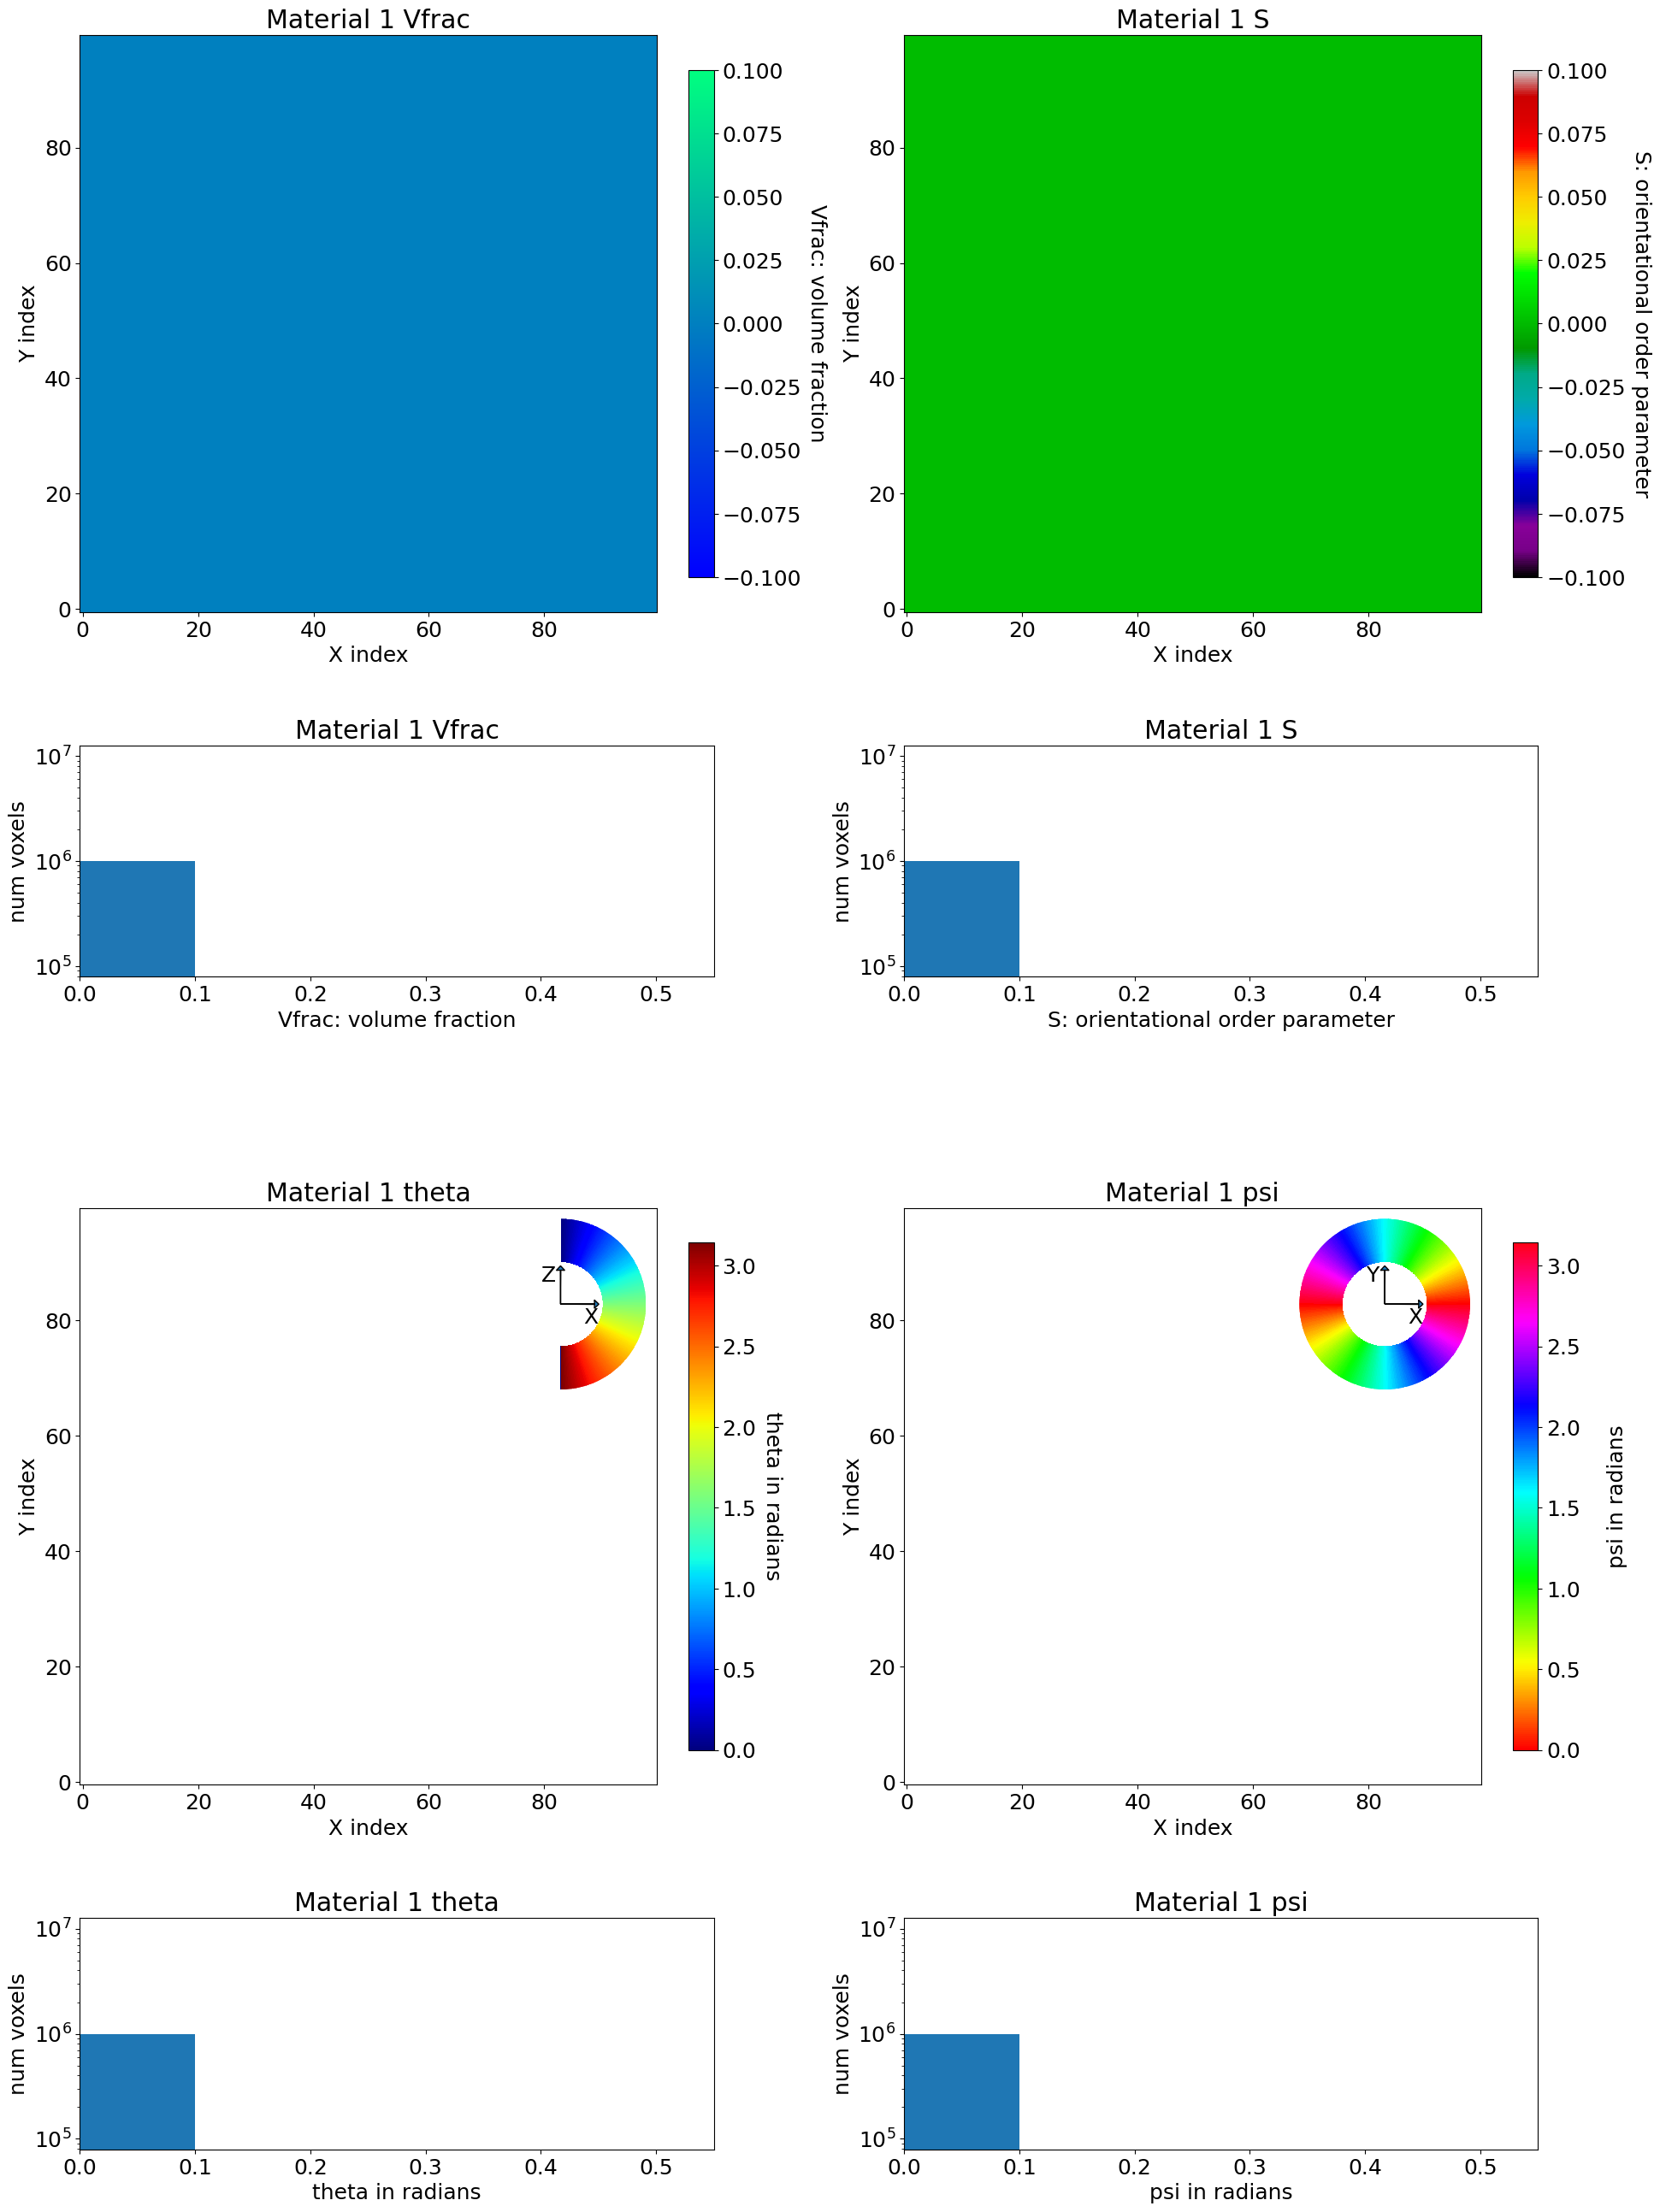

Material 2 Vfrac. Min: 0.0 Max: 1.0
Material 2 S. Min: 0.0 Max: 1.0
Material 2 theta. Min: 0.0 Max: 1.4340002502872329
Material 2 psi. Min: 0.0 Max: 1.8988259090499569


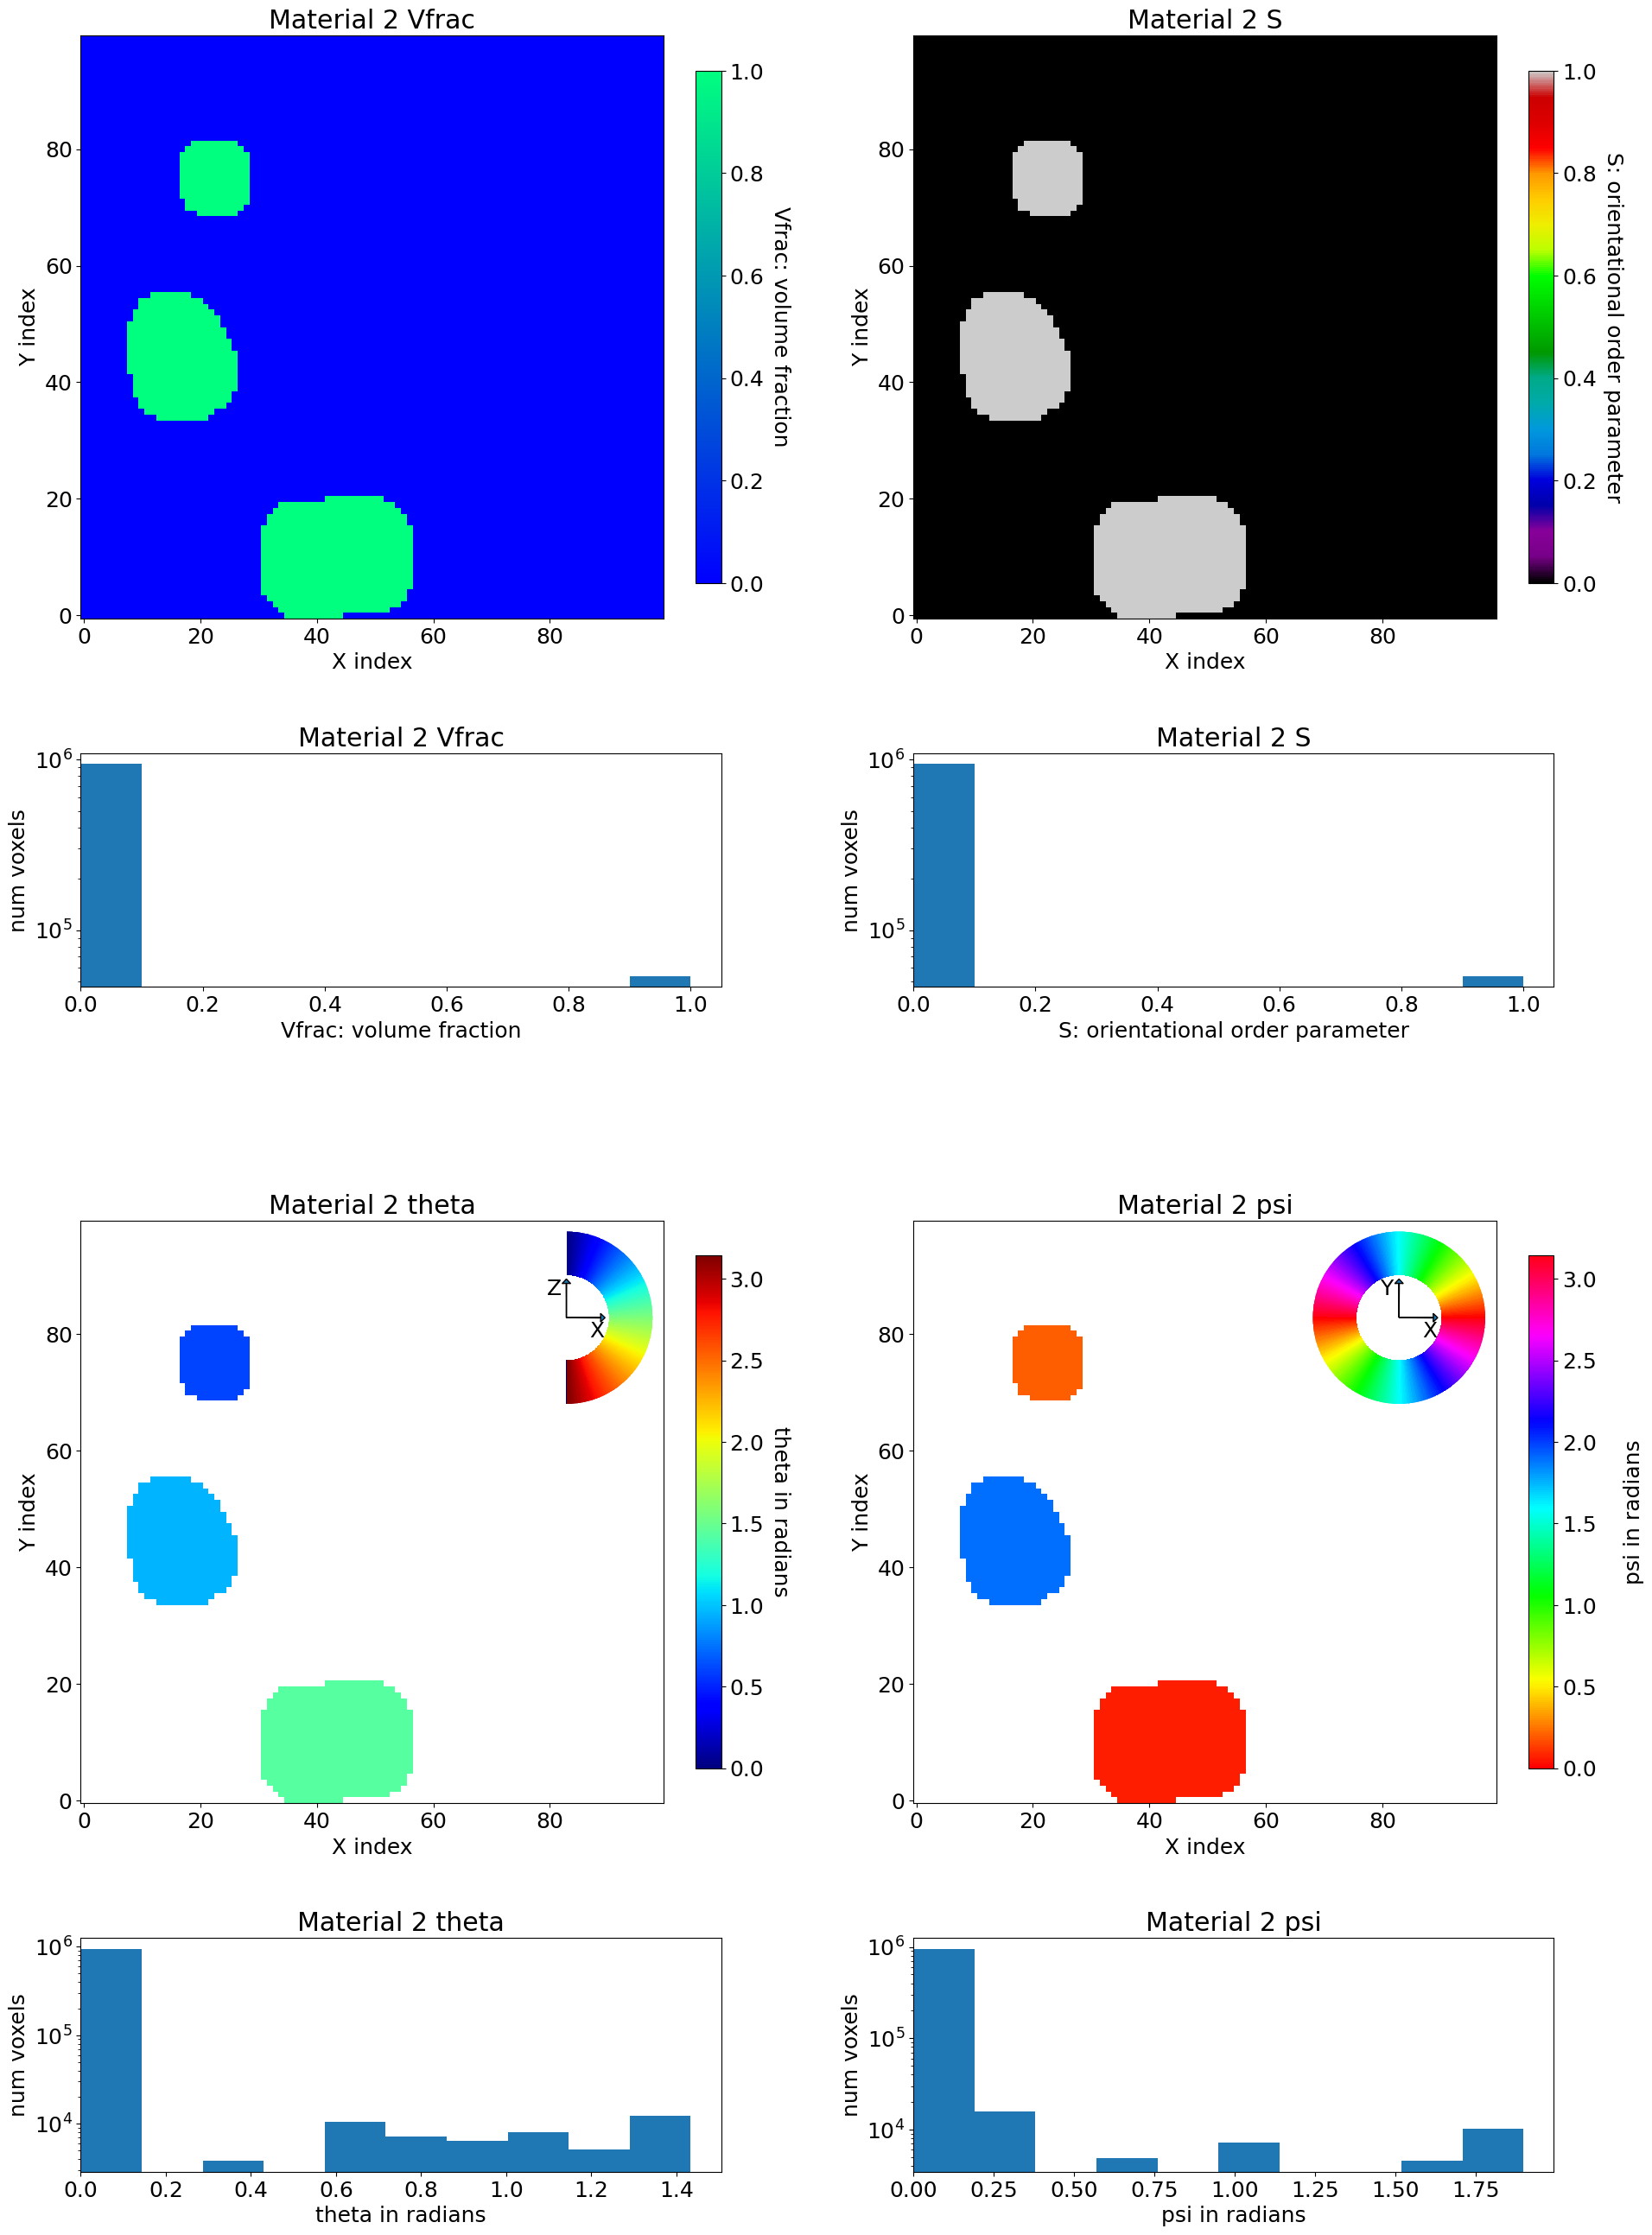

Material 3 Vfrac. Min: 0.0 Max: 0.9128178844863388
Material 3 S. Min: 0.0 Max: 1.0
Material 3 theta. Min: 0.0 Max: 3.1407757878469775
Material 3 psi. Min: 0.0 Max: 3.1415922420061917


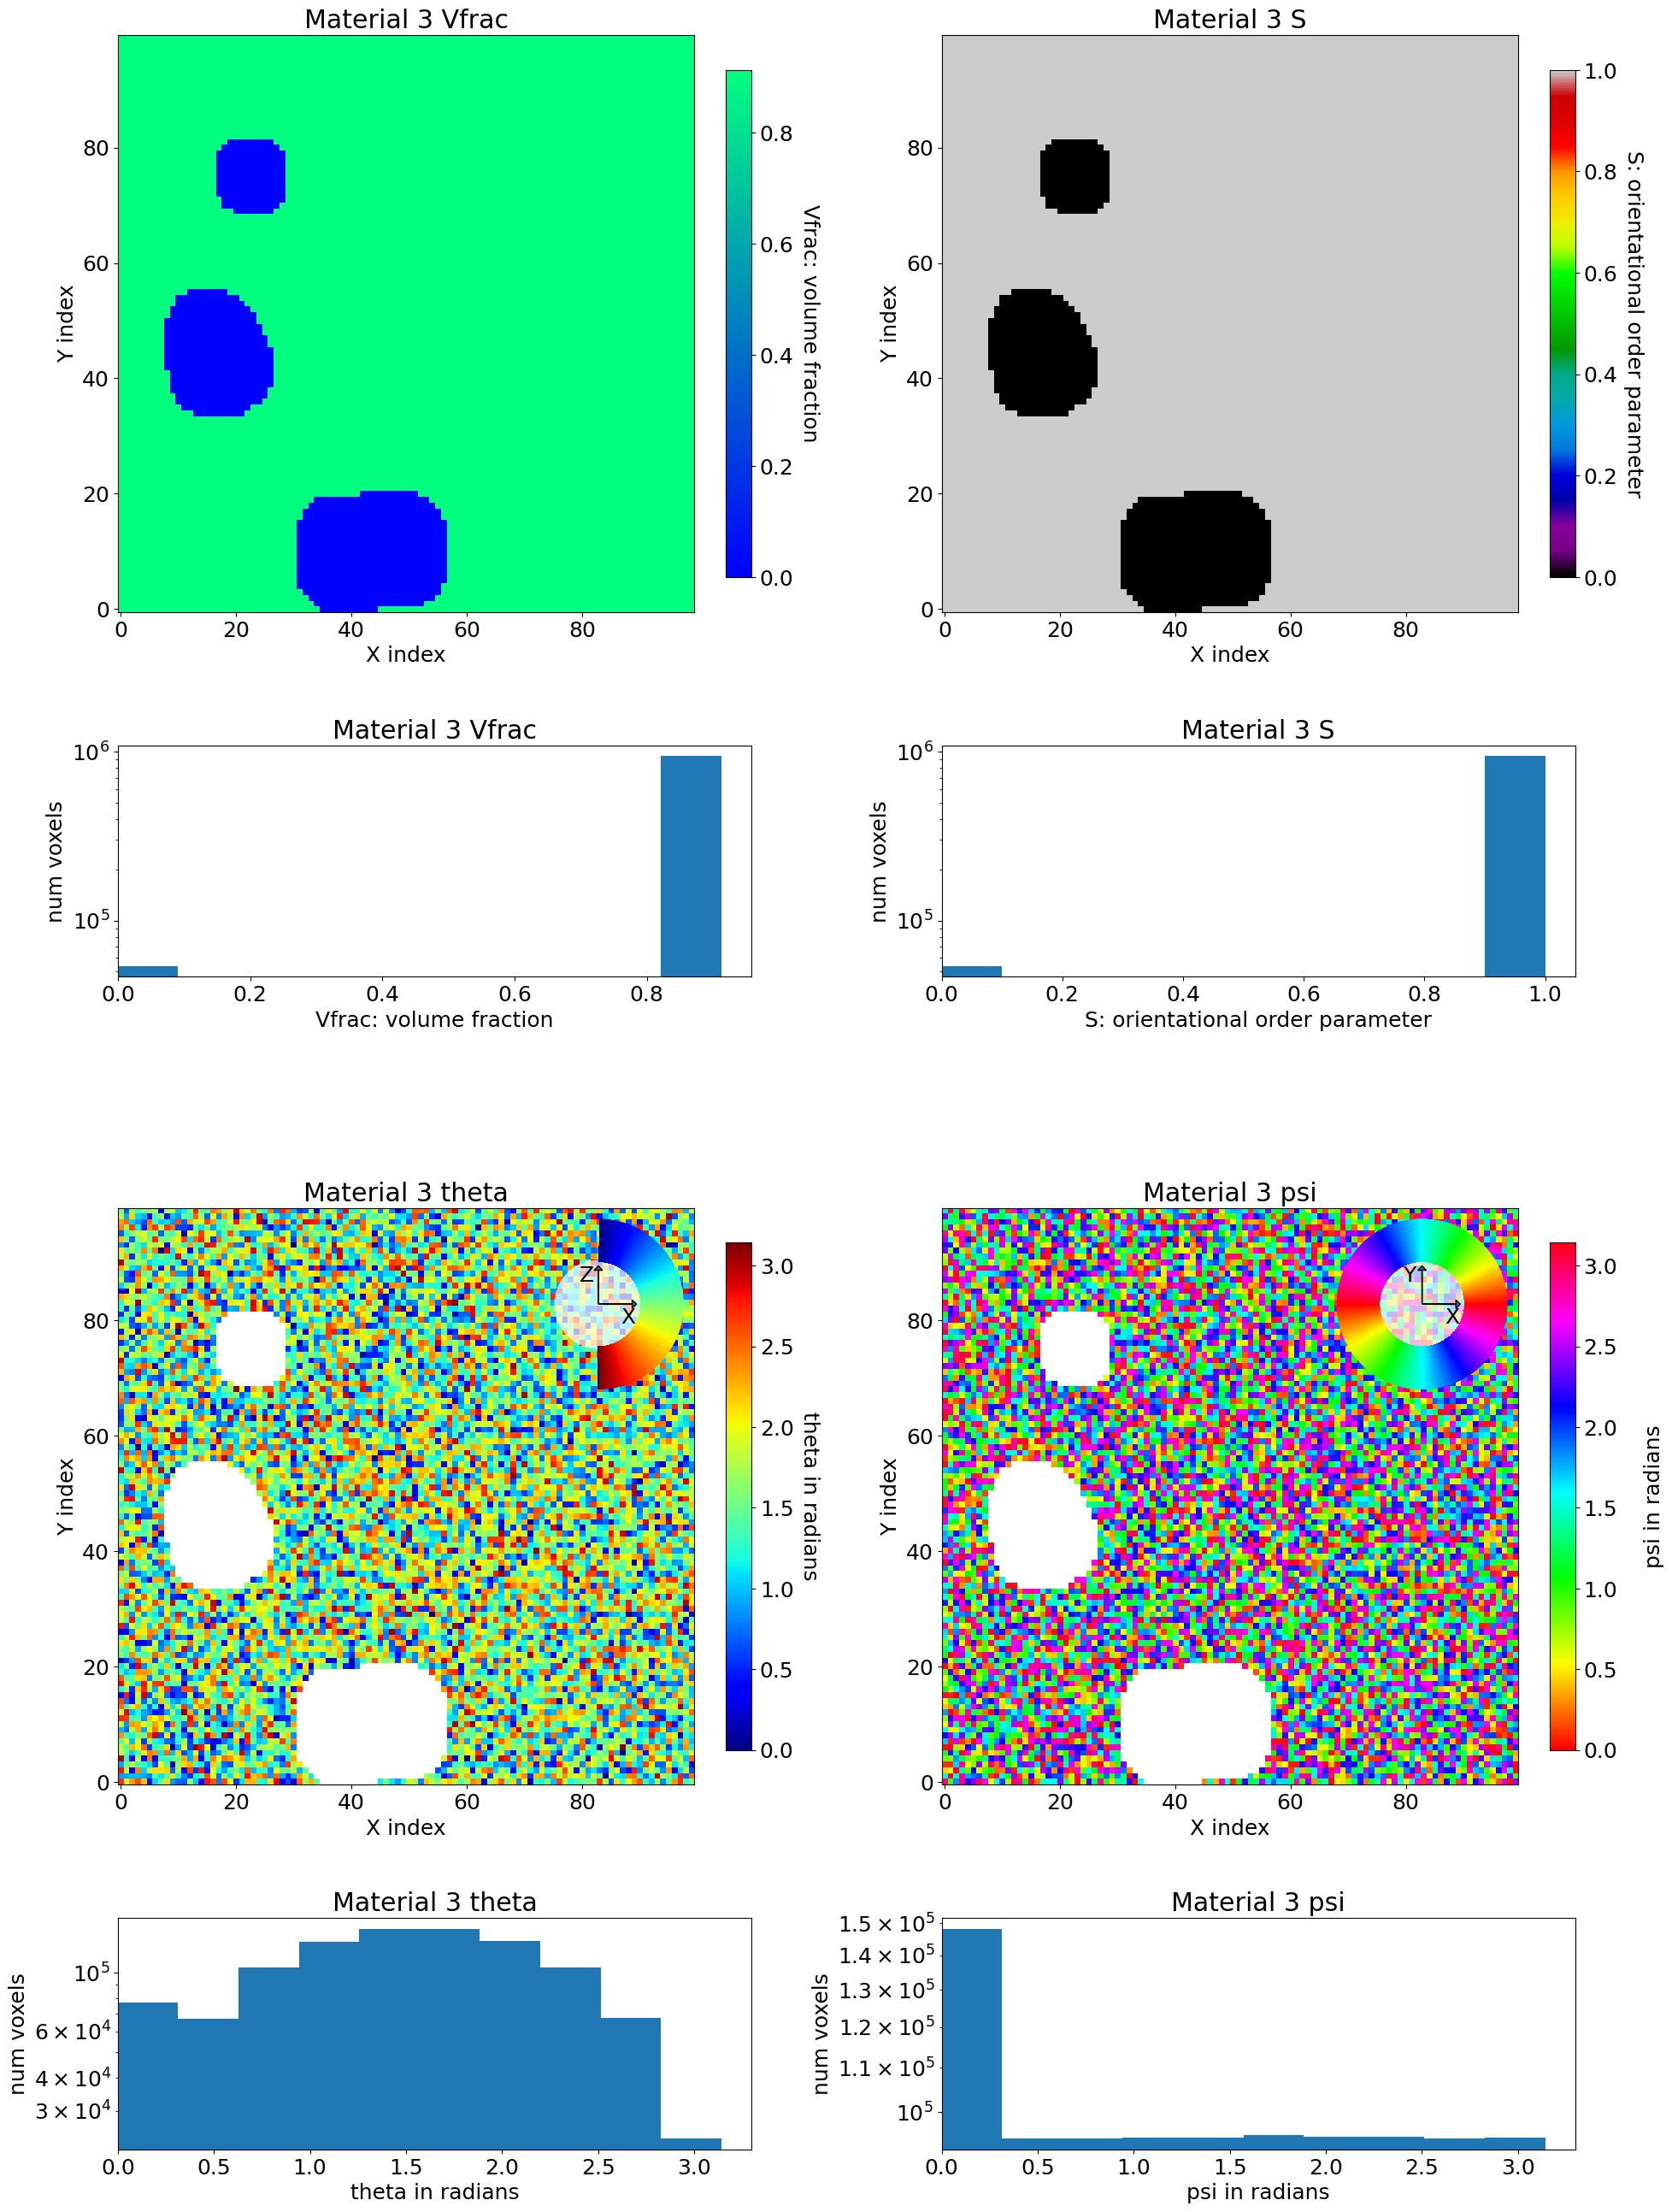

Material 4 Vfrac. Min: 0.0 Max: 0.08718211551366117
Material 4 S. Min: 0.0 Max: 1.0
Material 4 theta. Min: 0.0 Max: 3.13891134545087
Material 4 psi. Min: 0.0 Max: 3.1415916440462412


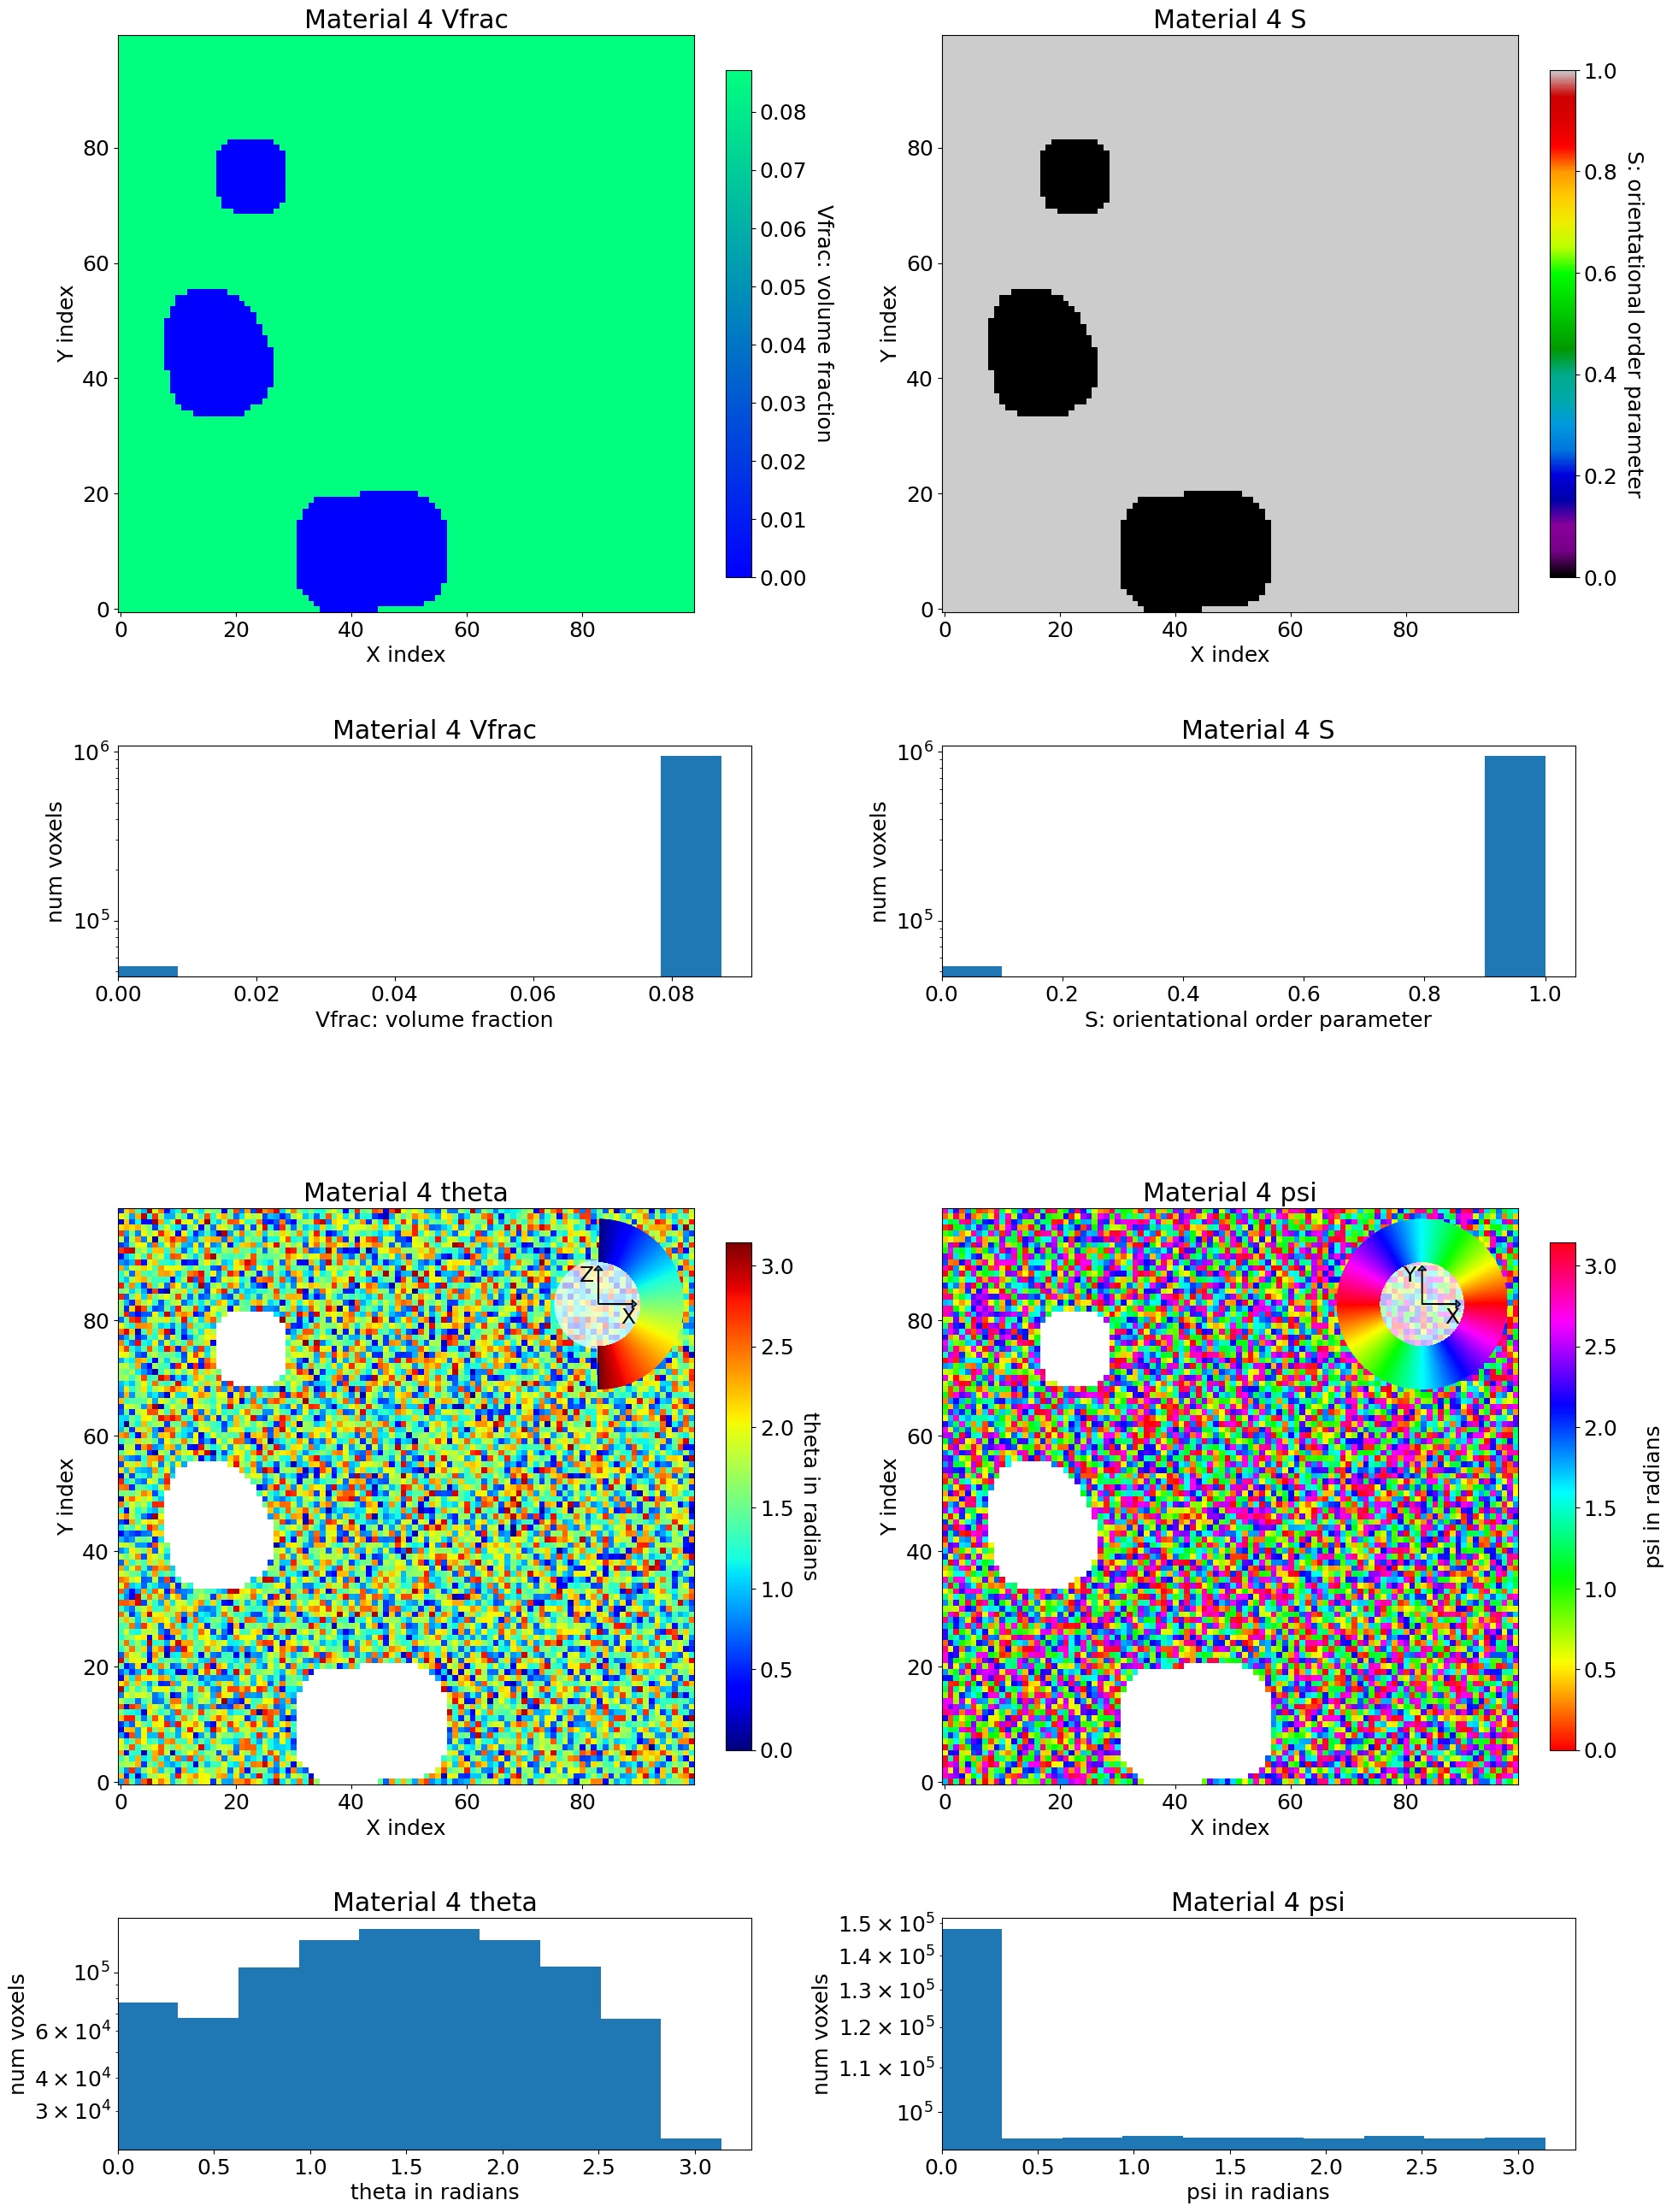

Total Vfrac whole model. Min: 1.0 Max: 1.0
0:00:11.718918


In [81]:
checkH5('Fibril.hdf5', z_slice=55, plotstyle='light')

In [69]:
import os
import pickle
from PostProcessor import PostProcessor

VACUUM_ID  = 0 # Vacuum
CRYSTAL_ID = 1 # Crystalline P3HT
AMORPH_ID  = 2 # Amorphous P3HT
DOPANT_ID  = 3 # Dopant (optional)

mol_weight = {
    CRYSTAL_ID: 166.2842, # Molecular weight of crystalline P3HT
    AMORPH_ID: 166.2842,  # Molecular weight of amorphous P3HT
    DOPANT_ID: 280.14     # Molecular weight of TFSI- = 280.14, Molecular weight of F4TCNQ = 276.15
}

density = {
    CRYSTAL_ID: 1.1, # Density of crystalline P3HT
    AMORPH_ID: 1.1,  # Density of amorphous P3HT
    DOPANT_ID: 1.1   # Density of dopant in P3HT
}


# PostProcessor Setup
post_processor = PostProcessor(
    num_materials=4, mol_weight=mol_weight, density=density,
    dope_case=1, dopant_method='uniform', dopant_orientation='isotropic', dopant_frac=0.0825, 
    core_shell_morphology=True, gaussian_std=3, fibril_shell_cutoff=0.2, 
    surface_roughness=False, height_feature=3,max_valley_nm=46, 
    amorph_matrix_Vfrac=1, amorphous_orientation=False)

pickle_files = []

# Iterate through all subdirectories and find all .pickle files
for root, dirs, files in os.walk('.'):
    for filename in files:
        if filename.endswith('.pickle') and 'HDF5' not in os.listdir(root):
            full_path = os.path.abspath(os.path.join(root, filename))
            mtime = os.path.getmtime(full_path)
            pickle_files.append((mtime, full_path))

# Sort the files by their modification times (oldest first)
pickle_files.sort()

print(f"{'File Name':<80} | {'Aggregate Fraction'}")

# Process the sorted files
for mtime, full_path in pickle_files:
    with open(full_path, 'rb') as f:
        rm = pickle.load(f)

    mat_Vfrac, mat_S, mat_theta, mat_psi = post_processor.generate_material_matricies(rm)
    crystalline_mol_fraction, amorphous_mol_fraction, dopant_mol_fraction = post_processor.analyze_mol_fractions(mat_Vfrac, mol_weight, density)
    agg_frac = crystalline_mol_fraction / (crystalline_mol_fraction + amorphous_mol_fraction)
    print(f"{full_path:<80} | {agg_frac}")

TypeError: __init__() got an unexpected keyword argument 'dopant_frac'

# Visualize morphology:

In [54]:
def array2voxel(voxel_array):
    """
    convert a to a fixed size array to voxel_grid_index array
    (voxel_size*voxel_size*voxel_size)->(N*3)
    
    :input voxel_array: array with shape(voxel_size*voxel_size*voxel_size),the grid_index in 
    :return grid_index_array: get from o3d.voxel_grid.get_voxels()
    """
    x,y,z=np.where(voxel_array>0)
    voxel_mask = np.where(voxel_array>0)
    # x,y,z = voxel_mask
    valid_voxels = voxel_array[voxel_mask]
    index_voxel=np.vstack((x,y,z))
    grid_index_array=index_voxel.T
    return grid_index_array, valid_voxels

# frame = o3d.geometry.TriangleMesh.create_coordinate_frame(1)
voxel_array = mat_Vfrac[1]
# voxel_array = np.where(mat_Vfrac[0]<1,1,0)
grid_index_array, valid_voxels = array2voxel(voxel_array)
pointcloud_array=grid_index_array*0.03125#0.03125 is voxel_size
pc=o3d.geometry.PointCloud()
pc.points = o3d.utility.Vector3dVector(pointcloud_array)

color_max_array = np.array([[100], [100], [100]])
colors = np.dot(color_max_array, [valid_voxels]).T
pc.colors = o3d.utility.Vector3dVector(colors / 255.0)
print("pc created")

o3d_voxel=o3d.geometry.VoxelGrid.create_from_point_cloud(pc, voxel_size=0.03125)
print("Voxel created")
o3d.visualization.draw_geometries([o3d_voxel])

pc created
Voxel created


In [45]:
from pyvox.models import Vox
from pyvox.writer import VoxWriter
combmatFrac = mat_Vfrac[1]+mat_Vfrac[2]
voxmat = [[Vox.from_dense(np.ceil(combmatFrac[:,256*n:256*(n+1),256*m:256*(m+1)]).astype(int)) for n in range(2)] for m in range(2)]
[[VoxWriter(f'voxFile{a}x_{b}y.vox',voxmat[a][b]).write() for a in range(2)] for b in range(2)]

[[None, None], [None, None]]

In [5]:
from pyvox.models import Vox
from pyvox.writer import VoxWriter
fibMat = mat_Vfrac[1]
fibVox = [[Vox.from_dense(np.ceil(fibMat[:,256*n:256*(n+1),256*m:256*(m+1)]).astype(int)) for n in range(2)] for m in range(2)]
[[VoxWriter(f'FibvoxFile{a}x_{b}y.vox',fibVox[a][b]).write() for a in range(2)] for b in range(2)]
del fibVox
del fibMat
shellMat = np.where(mat_Vfrac[2]==1,1,0)
shellVox = [[Vox.from_dense(np.ceil(shellMat[:,256*n:256*(n+1),256*m:256*(m+1)]).astype(int)) for n in range(2)] for m in range(2)]
[[VoxWriter(f'ShellvoxFile{a}x_{b}y.vox',shellVox[a][b]).write() for a in range(2)] for b in range(2)]
del shellMat
del shellVox
matMat = np.where(mat_Vfrac[2]==0.9,1,0)
matVox = [[Vox.from_dense(np.ceil(matMat[:,256*n:256*(n+1),256*m:256*(m+1)]).astype(int)) for n in range(2)] for m in range(2)]
[[VoxWriter(f'MatvoxFile{a}x_{b}y.vox',matVox[a][b]).write() for a in range(2)] for b in range(2)]
del matMat
del matVox


In [57]:
import matplotlib as mpl
all_mats = (mat_Vfrac[1] + mat_Vfrac[2] + mat_Vfrac[3]).astype(bool)

height_map = np.zeros_like(all_mats[0,:,:],dtype=int)
for x in range(all_mats.shape[2]):
    for y in range(all_mats.shape[1]):
        # highest occupied index in z:
        height_map[y,x] = np.max(np.where(all_mats[:,y,x]))


([], [])

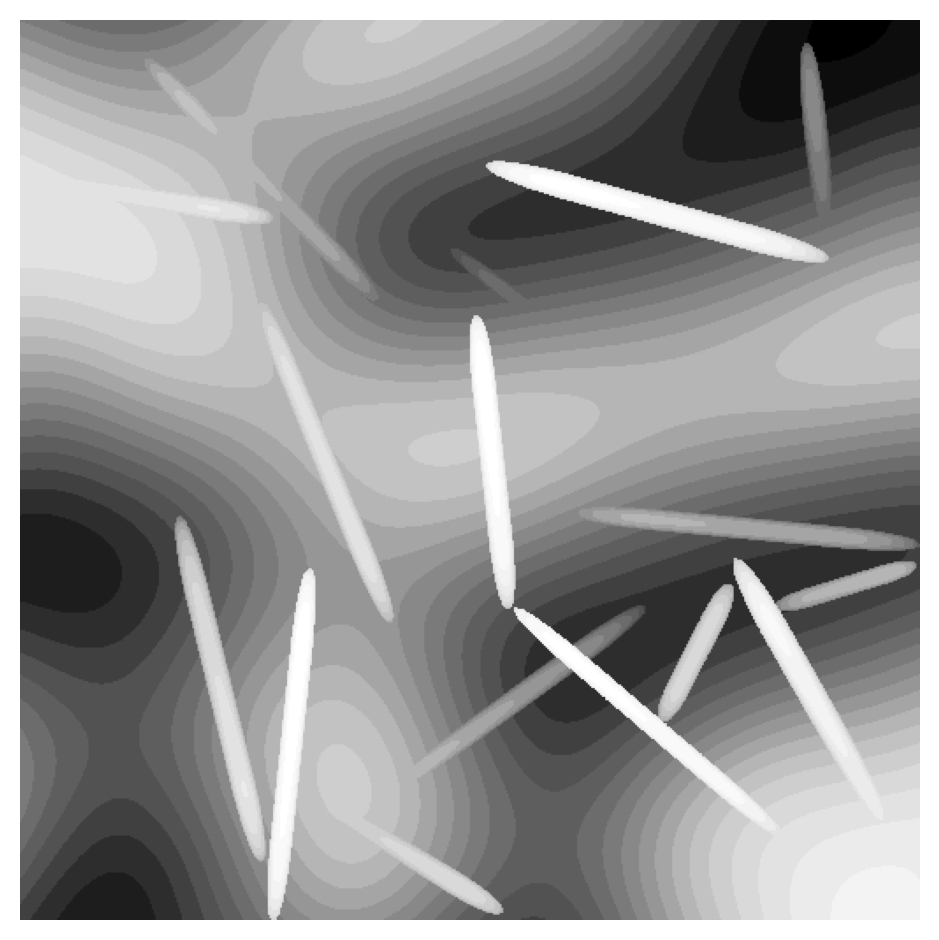

In [58]:

fig,ax = plt.subplots(dpi=200)
plt.axis('off')
plt.imshow(height_map, cmap = mpl.colormaps['Greys_r'])
fig.set_tight_layout(True)
# fig.s
plt.xticks([])
plt.yticks([])
# plt.colorbar()


In [5]:
basePath = pathlib.Path('C:/Users/Phong/Box/Research/Mixed Conduction Project/RSOXS Projects/Shared RSoXS Folder/CyRSoXS Processing/CyRSoXS Simulation Results/Phong_Data/').absolute()
resultsPath = pathlib.Path(basePath,'test/')
h5path = pathlib.Path(resultsPath,'HDF5')
h5list = list(sorted(h5path.glob('*h5')))

In [6]:
def print_key(f, key):
    try:
        keys2 = f[key].keys()
        for key2 in keys2:
            new_key = key + '/' + key2
            print_key(f, new_key)
    except AttributeError:
        print(key)

with h5py.File(h5list[0],'r') as f:
    for key in f.keys():
        print_key(f, key)

K0/projection
KIDList/KVec


In [7]:
load = cyrsoxsLoader()
integ = WPIntegrator(force_np_backend=True) # avoiding gpu backend for this tutorial

In [8]:
raw = load.loadDirectory(resultsPath)

C:\Users\Phong\anaconda3\envs\smi_analysis\lib\site-packages\PyHyperScattering\cyrsoxsLoader.py:209: UserWarning: No morphology file found. Using default PhysSize of 5 nm.
  warnings.warn('No morphology file found. Using default PhysSize of 5 nm.')


KeyboardInterrupt: 

In [ ]:
remeshed = integ.integrateImageStack(raw)

In [ ]:
# calculate the anisotropy metric
A = remeshed.rsoxs.AR(chi_width=20)

In [ ]:
A.plot(x='q',cmap='bwr_r', vmin=-0.2, vmax=0.2)
plt.xlim(left=0.01, right=0.1)
plt.ylim(bottom=280, top=292)
plt.xscale('linear')
plt.show()